<a href="https://colab.research.google.com/github/racoope70/exploratory_daytrading/blob/main/ppo_alpaca_paper_trading_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Clean any partials
!pip uninstall -y stable-baselines3 shimmy gymnasium gym autorom AutoROM.accept-rom-license ale-py

# Install the compatible trio (no [extra] to avoid Atari deps)
!pip install "gymnasium==0.29.1" "shimmy==1.3.0" "stable-baselines3==2.3.0"

# Your other libs (safe to keep separate)
!pip install alpaca-trade-api ta python-dotenv gym-anytrading


Found existing installation: gymnasium 1.2.0
Uninstalling gymnasium-1.2.0:
  Successfully uninstalled gymnasium-1.2.0
Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Found existing installation: ale-py 0.11.2
Uninstalling ale-py-0.11.2:
  Successfully uninstalled ale-py-0.11.2
Reason for being yanked: Loading broken with PyTorch 1.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 12.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, which is not installed.
dopamine-rl 4.1.2 requires gym<=0.25.2, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
  Preparing metadata (setup.py) ... done
  

In [2]:
import torch, gymnasium, shimmy, stable_baselines3 as sb3
import alpaca_trade_api, websockets, pywt

print("torch:", torch.__version__)
print("gymnasium:", gymnasium.__version__)
print("shimmy:", shimmy.__version__)
print("stable-baselines3:", sb3.__version__)
print("alpaca-trade-api:", alpaca_trade_api.__version__)
print("websockets:", websockets.__version__)
print("pywavelets:", pywt.__version__)


torch: 2.8.0+cu126
gymnasium: 0.29.1
shimmy: 1.3.0
stable-baselines3: 2.3.0
alpaca-trade-api: 3.2.0
websockets: 10.4
pywavelets: 1.8.0


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Upload your .env (or Alpaca_keys.env.txt). Cancel if already on Drive.


Saving Alpaca_keys.env.txt to Alpaca_keys.env.txt
Saved env → /content/drive/MyDrive/AlpacaPaper/.env
Upload your artifacts (ppo_*_model.zip, *_vecnorm.pkl, *_features.json or .txt).


Saving ppo_CVX_window1_features.json to ppo_CVX_window1_features (2).json
Saving ppo_CVX_window1_model_info.json to ppo_CVX_window1_model_info (2).json
Saving ppo_CVX_window1_model.zip to ppo_CVX_window1_model (2).zip
Saving ppo_CVX_window1_probability_config.json to ppo_CVX_window1_probability_config (2).json
Saving ppo_CVX_window1_vecnorm.pkl to ppo_CVX_window1_vecnorm (2).pkl
Saving ppo_GE_window1_features.json to ppo_GE_window1_features (2).json
Saving ppo_GE_window1_model_info.json to ppo_GE_window1_model_info (2).json
Saving ppo_GE_window1_model.zip to ppo_GE_window1_model (2).zip
Saving ppo_GE_window1_probability_config.json to ppo_GE_window1_probability_config (2).json
Saving ppo_GE_window1_vecnorm.pkl to ppo_GE_window1_vecnorm (2).pkl
Saving ppo_UNH_window3_features.json to ppo_UNH_window3_features (2).json
Saving ppo_UNH_window3_model_info.json to ppo_UNH_window3_model_info (2).json
Saving ppo_UNH_window3_model.zip to ppo_UNH_window3_model (2).zip
Saving ppo_UNH_window3_proba

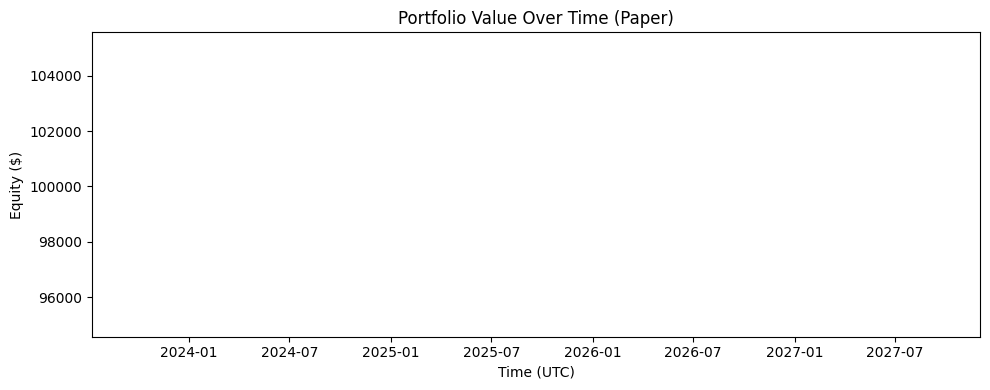

In [11]:
# Imports & Setup 
import os, re, json, csv, shutil, logging, pickle, warnings, time, math, gc
from pathlib import Path
from datetime import datetime, timedelta, timezone
from typing import Dict, Optional, Tuple, Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame, APIError
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecNormalize

# Detect Colab and mount Drive 
IN_COLAB = False
try:
    import google.colab  # type: ignore
    from google.colab import drive, files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    try:
        drive.mount("/content/drive", force_remount=False)
    except Exception:
        pass

# Project paths (Drive in Colab; cwd locally) 
if IN_COLAB:
    PROJECT_ROOT = Path("/content/drive/MyDrive/AlpacaPaper")
else:
    PROJECT_ROOT = Path.cwd() / "AlpacaPaper"

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
RESULTS_DIR   = PROJECT_ROOT / "results"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Optional: Upload helpers (Colab only) 
def upload_env_and_artifacts_in_colab():
    """
    In Colab this will prompt for:
      1) .env (or Alpaca_keys.env.txt)  -> moves to PROJECT_ROOT/.env
      2) Any model/feature/vecnorm files -> moves to ARTIFACTS_DIR

    Comment out this function call if you don't want upload prompts.
    """
    if not IN_COLAB:
        return

    print("Upload your .env (or Alpaca_keys.env.txt). Cancel if already on Drive.")
    up = files.upload()
    if up:
        # Try common names
        if "Alpaca_keys.env.txt" in up:
            src = Path("Alpaca_keys.env.txt")
            dst = PROJECT_ROOT / ".env"
            shutil.move(str(src), str(dst))
            print(f"Saved env → {dst}")
        elif ".env" in up:
            src = Path(".env")
            dst = PROJECT_ROOT / ".env"
            shutil.move(str(src), str(dst))
            print(f"Saved env → {dst}")
        else:
            # If user picked a different name, move the first file to .env
            any_name = next(iter(up.keys()))
            src = Path(any_name)
            dst = PROJECT_ROOT / ".env"
            shutil.move(str(src), str(dst))
            print(f"Saved env (renamed {any_name}) → {dst}")

    print("Upload your artifacts (ppo_*_model.zip, *_vecnorm.pkl, *_features.json or .txt).")
    up2 = files.upload()
    for name in up2.keys():
        shutil.move(name, ARTIFACTS_DIR / name)
    print("Artifacts now in:", sorted(p.name for p in ARTIFACTS_DIR.iterdir()))

def _maybe_convert_features_txt_to_json():
    """
    Convert any 'features_<TICKER>.txt' into 'ppo_<TICKER>_features.json' (simple list).
    """
    for p in ARTIFACTS_DIR.glob("features_*.txt"):
        ticker = re.sub(r"^features_|\.txt$", "", p.name, flags=re.IGNORECASE)
        try:
            raw = p.read_text().strip()
            items = [x.strip() for x in raw.replace(",", "\n").splitlines() if x.strip()]
            out = {"features": items}
            out_path = ARTIFACTS_DIR / f"ppo_{ticker}_features.json"
            out_path.write_text(json.dumps(out, indent=2))
            print(f"Converted {p.name} → {out_path.name}  ({len(items)} features)")
        except Exception as e:
            print(f"Could not convert {p.name}: {e}")

def _maybe_rename_vecnorm_scaler():
    """
    Rename any 'scaler_<TICKER>.pkl' to 'ppo_<TICKER>_vecnorm.pkl'.
    """
    for p in ARTIFACTS_DIR.glob("scaler_*.pkl"):
        ticker = re.sub(r"^scaler_|\.pkl$", "", p.name, flags=re.IGNORECASE)
        dst = ARTIFACTS_DIR / f"ppo_{ticker}_vecnorm.pkl"
        if not dst.exists():
            shutil.move(str(p), str(dst))
            print(f"Renamed {p.name} → {dst.name}")

# (Optional) trigger uploads in Colab 
# Comment out the next line if you already have files on Drive in /MyDrive/AlpacaPaper/*
if IN_COLAB:
    upload_env_and_artifacts_in_colab()
    _maybe_convert_features_txt_to_json()
    _maybe_rename_vecnorm_scaler()

# Env & logging 
warnings.filterwarnings("ignore")

# Load env (supports PROJECT_ROOT/.env)
env_candidates = [PROJECT_ROOT / ".env", Path(".env")]
for env_path in env_candidates:
    if env_path.exists():
        load_dotenv(dotenv_path=env_path, override=True)
        break
else:
    load_dotenv(override=True)  # fallback to default search

logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

# Baseline env defaults (can be overridden by your .env or shell)
os.environ.setdefault("APCA_API_BASE_URL", "https://paper-api.alpaca.markets")
os.environ.setdefault("DRY_RUN", "0")                 # 0 => place PAPER orders on PAPER endpoint
os.environ.setdefault("AUTO_RUN_LIVE", "1")           # loop when market open
os.environ.setdefault("SIZING_MODE", "linear")        # or "threshold"
os.environ.setdefault("WEIGHT_CAP", "0.25")           # max 25% per symbol
os.environ.setdefault("CONF_FLOOR", "0.10")           # used if threshold sizing
os.environ.setdefault("ENTER_CONF_MIN", "0.08")
os.environ.setdefault("ENTER_WEIGHT_MIN", "0.015")
os.environ.setdefault("EXIT_WEIGHT_MAX", "0.003")
os.environ.setdefault("COOLDOWN_MIN", "5")
os.environ.setdefault("TAKE_PROFIT_PCT", "0.05")
os.environ.setdefault("STOP_LOSS_PCT", "0.03")
os.environ.setdefault("BARS_FEED", "iex")
os.environ.setdefault("INF_DETERMINISTIC", "1")
os.environ.setdefault("STALE_MAX_SEC", "120")
os.environ.setdefault("SEED_FIRST_SHARE", "1")
os.environ.setdefault("TICKERS", "ABT")               # < change to your tickers (comma-separated)
os.environ.setdefault("ARTIFACTS_DIR", str(ARTIFACTS_DIR))
os.environ.setdefault("RESULTS_DIR",   str(RESULTS_DIR))

# Resolve paths from env (single source of truth for outputs) 
ARTIFACTS_DIR = Path(os.getenv("ARTIFACTS_DIR", str(ARTIFACTS_DIR)))
RESULTS_DIR   = Path(os.getenv("RESULTS_DIR",   str(RESULTS_DIR)))
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

TRADE_LOG_CSV  = RESULTS_DIR / "trade_log_master.csv"   # optional master log
EQUITY_LOG_CSV = RESULTS_DIR / "equity_log.csv"
PLOT_PATH      = RESULTS_DIR / "equity_curve.png"

# Alpaca API config 
API_KEY    = os.getenv("APCA_API_KEY_ID")     or os.getenv("ALPACA_API_KEY_ID")     or ""
API_SECRET = os.getenv("APCA_API_SECRET_KEY") or os.getenv("ALPACA_API_SECRET_KEY") or ""
BASE_URL   = os.getenv("APCA_API_BASE_URL")   or os.getenv("ALPACA_API_BASE_URL")   or "https://paper-api.alpaca.markets"

# Runtime knobs -
BEST_WINDOW_ENV   = (os.getenv("BEST_WINDOW", "").strip() or None)  # e.g., "3"
TICKERS           = [s.strip() for s in os.getenv("TICKERS", "ABT").split(",") if s.strip()]
BARS_FEED         = os.getenv("BARS_FEED", "iex").strip()
DRY_RUN           = os.getenv("DRY_RUN", "1").lower() in ("1","true","yes")
INF_DETERMINISTIC = os.getenv("INF_DETERMINISTIC", "1").lower() in ("1","true","yes")
COOLDOWN_MIN      = int(os.getenv("COOLDOWN_MIN", "5"))
STALE_MAX_SEC     = int(os.getenv("STALE_MAX_SEC", "120"))

# Entry/exit sensitivity
SIZING_MODE       = os.getenv("SIZING_MODE", "linear")          # "linear" | "threshold"
WEIGHT_CAP        = float(os.getenv("WEIGHT_CAP", "0.25"))
ENTER_CONF_MIN    = float(os.getenv("ENTER_CONF_MIN", "0.08"))
ENTER_WEIGHT_MIN  = float(os.getenv("ENTER_WEIGHT_MIN", "0.015"))
EXIT_WEIGHT_MAX   = float(os.getenv("EXIT_WEIGHT_MAX", "0.003"))
SEED_FIRST_SHARE  = os.getenv("SEED_FIRST_SHARE","1").lower() in ("1","true","yes")

# Sizing / TP-SL
CONF_FLOOR      = float(os.getenv("CONF_FLOOR", "0.20"))    # Threshold mode only
TAKE_PROFIT_PCT = float(os.getenv("TAKE_PROFIT_PCT", "0.05"))
STOP_LOSS_PCT   = float(os.getenv("STOP_LOSS_PCT", "0.03"))

# Time helpers 
def now_utc() -> datetime:
    return datetime.now(timezone.utc)

def utc_ts(dt_like) -> int:
    """
    Return epoch seconds (UTC) for int/float epochs, datetimes, strings, numpy datetime, etc.
    """
    # Fast paths for numbers
    if isinstance(dt_like, (int, np.integer)):
        return int(dt_like)
    if isinstance(dt_like, (float, np.floating)):
        return int(dt_like)
    ts = pd.Timestamp(dt_like)
    if ts.tzinfo is None:
        ts = ts.tz_localize("UTC")
    else:
        ts = ts.tz_convert("UTC")
    return int(ts.value // 10**9)

def utcnow_iso() -> str:
    return datetime.now(timezone.utc).isoformat()

# Env override helpers 
def apply_env_overrides(verbose: bool = False):
    """Re-read SIZING_MODE / CONF_FLOOR from environment and update the globals."""
    global SIZING_MODE, CONF_FLOOR
    old_mode, old_floor = SIZING_MODE, CONF_FLOOR
    SIZING_MODE = os.getenv("SIZING_MODE", SIZING_MODE)
    CONF_FLOOR  = float(os.getenv("CONF_FLOOR", str(CONF_FLOOR)))
    if verbose:
        print(f"SIZING_MODE: {old_mode} -> {SIZING_MODE}")
        print(f"CONF_FLOOR:  {old_floor:.2f} -> {CONF_FLOOR:.2f}")

def apply_risk_overrides(verbose: bool = True):
    """Re-read TAKE_PROFIT_PCT / STOP_LOSS_PCT from env and update globals."""
    global TAKE_PROFIT_PCT, STOP_LOSS_PCT
    old_tp, old_sl = TAKE_PROFIT_PCT, STOP_LOSS_PCT
    TAKE_PROFIT_PCT = float(os.getenv("TAKE_PROFIT_PCT", str(TAKE_PROFIT_PCT)))
    STOP_LOSS_PCT   = float(os.getenv("STOP_LOSS_PCT",   str(STOP_LOSS_PCT)))
    if verbose:
        print(f"TAKE_PROFIT_PCT: {old_tp:.4f} -> {TAKE_PROFIT_PCT:.4f}")
        print(f"STOP_LOSS_PCT:   {old_sl:.4f} -> {STOP_LOSS_PCT:.4f}")

# CSV logging (master, optional) 
def ensure_trade_log_header():
    if not TRADE_LOG_CSV.exists():
        pd.DataFrame([{
            "datetime_utc": "", "ticker": "", "signal": np.nan, "action": "",
            "price": np.nan, "equity": np.nan, "qty": np.nan, "comment": ""
        }]).iloc[0:0].to_csv(TRADE_LOG_CSV, index=False)

def log_trade(ticker:str, signal:float, action:str, price:float, equity:float, qty:float=None, comment:str=""):
    """Append one row to the (optional) master trade log CSV."""
    ensure_trade_log_header()
    row = {
        "datetime_utc": utcnow_iso(),
        "ticker": ticker,
        "signal": signal,
        "action": action,    # "BUY" | "SELL" | "HOLD" | "FLATTEN"
        "price": float(price) if price is not None else np.nan,
        "equity": float(equity) if equity is not None else np.nan,
        "qty": float(qty) if qty is not None else np.nan,
        "comment": str(comment) if comment else ""
    }
    df_new = pd.DataFrame([row])
    if TRADE_LOG_CSV.exists():
        df_old = pd.read_csv(TRADE_LOG_CSV)
        pd.concat([df_old, df_new], ignore_index=True).to_csv(TRADE_LOG_CSV, index=False)
    else:
        df_new.to_csv(TRADE_LOG_CSV, index=False)

# Alpaca API init 
def init_alpaca() -> "tradeapi.REST":
    if not API_KEY or not API_SECRET:
        raise RuntimeError("Missing Alpaca API keys (check your .env).")
    api = tradeapi.REST(API_KEY, API_SECRET, base_url=BASE_URL)
    _ = api.get_account()  # sanity call
    return api

# Portfolio equity logging + metrics 
def fetch_portfolio_history(period="1M", timeframe="1Hour"):
    """Return equity history as a tidy DataFrame with UTC timestamps."""
    hist = api.get_portfolio_history(period=period, timeframe=timeframe)
    df = pd.DataFrame({
        "timestamp_utc": pd.to_datetime(hist.timestamp, unit="s", utc=True),
        "equity": pd.Series(hist.equity, dtype="float64")
    }).dropna()
    return df

def log_equity_snapshot():
    """Append the latest portfolio equity point (if new) to the EQUITY_LOG_CSV."""
    snap = fetch_portfolio_history(period="1D", timeframe="5Min")
    if snap.empty:
        return
    latest = snap.iloc[-1:].copy()
    latest.rename(columns={"timestamp_utc": "datetime_utc"}, inplace=True)

    if EQUITY_LOG_CSV.exists():
        df_old = pd.read_csv(EQUITY_LOG_CSV, parse_dates=["datetime_utc"])
        merged = pd.concat([df_old, latest], ignore_index=True)
        merged.drop_duplicates(subset=["datetime_utc"], keep="last").to_csv(EQUITY_LOG_CSV, index=False)
    else:
        latest.to_csv(EQUITY_LOG_CSV, index=False)

def plot_equity_curve(from_equity_csv: bool = True):
    if from_equity_csv and EQUITY_LOG_CSV.exists():
        df = pd.read_csv(EQUITY_LOG_CSV, parse_dates=["datetime_utc"]).sort_values("datetime_utc")
    else:
        df = fetch_portfolio_history(period="3M", timeframe="1Hour").rename(columns={"timestamp_utc":"datetime_utc"})
    if df.empty:
        print("No equity data to plot yet.")
        return
    plt.figure(figsize=(10,4))
    plt.plot(df["datetime_utc"], df["equity"])
    plt.title("Portfolio Value Over Time (Paper)")
    plt.xlabel("Time (UTC)")
    plt.ylabel("Equity ($)")
    plt.tight_layout()
    plt.savefig(PLOT_PATH)
    print(f"Saved equity curve → {PLOT_PATH}")

def compute_performance_metrics(df_equity: pd.DataFrame):
    """Compute cumulative return, Sharpe (hourly), max drawdown from an equity curve."""
    if df_equity.empty or df_equity["equity"].isna().all():
        return {"cum_return": np.nan, "sharpe_hourly": np.nan, "max_drawdown": np.nan}
    e = df_equity["equity"].astype(float)
    r = e.pct_change().dropna()
    ann_factor = 252 * 6.5  # hours/year approx
    sharpe = (r.mean() / (r.std() + 1e-12)) * math.sqrt(ann_factor) if len(r) > 1 else np.nan
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = (cum / peak - 1.0).min() if not cum.empty else np.nan
    cum_return = e.iloc[-1] / e.iloc[0] - 1.0 if len(e) > 1 else 0.0
    return {"cum_return": float(cum_return), "sharpe_hourly": float(sharpe), "max_drawdown": float(dd)}

# Hook for strategy loops 
def handle_signal_and_trade(ticker:str, signal:float, action:str, price:float, qty:int):
    """Call this right after you place/cancel an order."""
    log_equity_snapshot()
    eq_df = pd.read_csv(EQUITY_LOG_CSV, parse_dates=["datetime_utc"]) if EQUITY_LOG_CSV.exists() else pd.DataFrame()
    eq_val = float(eq_df.iloc[-1]["equity"]) if not eq_df.empty else np.nan
    log_trade(ticker=ticker, signal=signal, action=action, price=price, equity=eq_val, qty=qty)

# Per-ticker CSV logging 
def _append_csv_row(path: Path, row: dict):
    write_header = not path.exists()
    with path.open("a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=row.keys())
        if write_header:
            w.writeheader()
        w.writerow(row)

def log_trade_symbol(symbol: str,
                     bar_time,
                     signal: int,
                     raw_action: float,
                     weight: float,
                     confidence: float,
                     price: float,
                     equity: float,
                     dry_run: bool,
                     note: str = ""):
    try:
        bt_iso = pd.to_datetime(bar_time, utc=True).isoformat()
    except Exception:
        bt_iso = ""
    row = {
        "log_time": now_utc().isoformat(),
        "symbol": symbol,
        "bar_time": bt_iso,
        "signal": "BUY" if int(signal) == 1 else "SELL_OR_HOLD",
        "raw_action": float(raw_action) if np.isfinite(raw_action) else "",
        "weight": float(weight) if np.isfinite(weight) else "",
        "confidence": float(confidence) if np.isfinite(confidence) else "",
        "price": float(price) if np.isfinite(price) else "",
        "equity": float(equity) if np.isfinite(equity) else "",
        "dry_run": int(bool(dry_run)),
        "note": note,
    }
    _append_csv_row(RESULTS_DIR / f"trade_log_{symbol}.csv", row)

# Artifacts: picker & loaders 
def _extract_window_idx(path: Path) -> Optional[int]:
    m = re.search(r"_window(\d+)_", path.stem, re.IGNORECASE)
    if not m:
        return None
    try:
        return int(m.group(1))
    except Exception:
        return None

def pick_artifacts_for_ticker(
    ticker: str,
    artifacts_dir: str,
    best_window: Optional[str] = None
) -> Dict[str, Optional[Path]]:
    p = Path(artifacts_dir)
    if not p.exists():
        raise FileNotFoundError(f"Artifacts directory not found: {p.resolve()}")

    models = sorted(p.glob(f"ppo_{ticker}_window*_model.zip"))
    if not models:
        models = sorted(p.glob(f"ppo_{ticker}_model.zip")) or sorted(p.glob(f"*{ticker}*model.zip"))
        if not models:
            found = "\n".join(f" - {x.name}" for x in p.rglob("*model.zip"))
            raise FileNotFoundError(f"No PPO model for {ticker} in {p.resolve()}.\nSeen:\n{found or ' (none)'}")

    chosen: Optional[Path] = None
    if best_window:
        chosen = next((m for m in models if f"_window{best_window}_" in m.stem), None)
        if chosen is None:
            logging.warning("BEST_WINDOW=%s not found; falling back to best available.", best_window)

    if chosen is None:
        with_idx = [(m, _extract_window_idx(m)) for m in models]
        with_idx = [(m, w) for (m, w) in with_idx if w is not None]
        chosen = max(with_idx, key=lambda t: t[1])[0] if with_idx else models[-1]

    base    = chosen.stem.replace("_model", "")
    vecnorm = next(iter(sorted(p.glob(base + "_vecnorm.pkl"))), None)
    feats   = next(iter(sorted(p.glob(base + "_features.json"))), None)

    logging.info(f"[{ticker}] model={chosen.name} | vecnorm={bool(vecnorm)} | features={bool(feats)}")
    return {"model": chosen, "vecnorm": vecnorm, "features": feats}

def load_vecnormalize(path: Optional[Path]):
    if path is None:
        return None
    with open(path, "rb") as f:
        return pickle.load(f)

def load_features(path: Optional[Path]):
    if path is None:
        return None
    with open(path, "r") as f:
        return json.load(f)

def load_ppo_model(model_path: Path):
    return PPO.load(str(model_path))

# Market data + account helpers -
def get_recent_bars(api, symbol: str, limit: int = 200, timeframe=TimeFrame.Minute) -> pd.DataFrame:
    def _as_df(bars):
        if hasattr(bars, "df"):
            df = bars.df.copy()
            if not df.empty:
                if isinstance(df.index, pd.MultiIndex):
                    df = df.xs(symbol, level=0)
                df.index = pd.to_datetime(df.index, utc=True)
                df = df.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
                cols = [c for c in ["Open","High","Low","Close","Volume"] if c in df.columns]
                return df[cols].sort_index()
            return pd.DataFrame(columns=["Open","High","Low","Close","Volume"])
        rows = []
        for b in bars:
            ts = getattr(b, "t", None)
            ts = pd.to_datetime(ts, utc=True) if ts is not None else pd.NaT
            rows.append({
                "timestamp": ts,
                "Open":   float(getattr(b, "o", getattr(b, "open",  np.nan))),
                "High":   float(getattr(b, "h", getattr(b, "high",  np.nan))),
                "Low":    float(getattr(b, "l", getattr(b, "low",   np.nan))),
                "Close":  float(getattr(b, "c", getattr(b, "close", np.nan))),
                "Volume": float(getattr(b, "v", getattr(b, "volume",np.nan))),
            })
        df = pd.DataFrame(rows)
        if df.empty:
            return pd.DataFrame(columns=["Open","High","Low","Close","Volume"])
        return df.set_index(pd.to_datetime(df["timestamp"], utc=True)).drop(columns=["timestamp"]).sort_index()

    feed = os.getenv("BARS_FEED", "").strip()
    try:
        logging.info(f"[{symbol}] fetching {limit} {timeframe} bars (feed='{feed or 'default'}')")
        bars = api.get_bars(symbol, timeframe, limit=limit, feed=feed) if feed else api.get_bars(symbol, timeframe, limit=limit)
        df = _as_df(bars)
        if not df.empty:
            return df
    except Exception as e:
        logging.warning(f"[{symbol}] get_bars(limit) failed: {e}")

    # Fallback: explicit 5-day window
    try:
        end   = datetime.utcnow().replace(microsecond=0).isoformat() + "Z"
        start = (datetime.utcnow() - timedelta(days=5)).replace(microsecond=0).isoformat() + "Z"
        logging.info(f"[{symbol}] retry window start={start} end={end} (feed='{feed or 'default'}')")
        bars = api.get_bars(symbol, timeframe, start=start, end=end, feed=feed) if feed else api.get_bars(symbol, timeframe, start=start, end=end)
        return _as_df(bars)
    except Exception as e:
        logging.warning(f"[{symbol}] get_bars(start/end) failed: {e}")
        return pd.DataFrame(columns=["Open","High","Low","Close","Volume"])

def get_account_equity(api) -> float:
    return float(api.get_account().equity)

def get_position(api, symbol: str):
    try:
        return api.get_position(symbol)
    except Exception:
        return None

def get_position_qty(api, symbol: str) -> int:
    pos = get_position(api, symbol)
    if not pos:
        return 0
    try:
        return int(float(pos.qty))
    except Exception:
        return 0

def get_last_price(api, symbol: str) -> float:
    try:
        bars = api.get_bars(symbol, TimeFrame.Minute, limit=1, feed=os.getenv("BARS_FEED","") or None)
        if hasattr(bars, "df"):
            df = bars.df.copy()
            if isinstance(df.index, pd.MultiIndex):
                df = df.xs(symbol, level=0)
            if not df.empty:
                if "close" in df.columns: return float(df["close"].iloc[-1])
                if "Close" in df.columns: return float(df["Close"].iloc[-1])
        else:
            if len(bars) > 0:
                b = bars[0]
                close = getattr(b, "c", getattr(b, "close", None))
                if close is not None: return float(close)
    except Exception as e:
        logging.warning(f"[{symbol}] get_last_price via bars failed: {e}")
    try:
        pos = api.get_position(symbol)
        return float(pos.avg_entry_price)
    except Exception:
        return float("nan")

def cancel_open_symbol_orders(api, symbol: str):
    try:
        for o in api.list_orders(status="open"):
            if o.symbol == symbol:
                api.cancel_order(o.id)
    except Exception as e:
        logging.warning(f"[{symbol}] cancel orders failed: {e}")

def market_order_to_qty(api, symbol: str, side: str, qty: int):
    if qty <= 0:
        return None
    if DRY_RUN:
        logging.info(f"[DRY_RUN] Would submit {side} {qty} {symbol} (market, day)")
        return None
    try:
        o = api.submit_order(
            symbol=symbol,
            side=side,
            type="market",
            qty=qty,
            time_in_force="day"
        )
        logging.info(f"[{symbol}] Submitted {side} {qty} (market) id={o.id}")
        return o
    except Exception as e:
        logging.error(f"[{symbol}] submit_order failed: {e}")
        return None

# Sizing / risk + (un)flatten + rebalancer -
def action_to_weight(action) -> Tuple[float, float, float]:
    a = float(np.array(action).squeeze())
    conf = float(abs(np.tanh(a)))
    if a <= 0:
        return 0.0, conf, a
    if SIZING_MODE == "linear":
        w = WEIGHT_CAP * conf
    else:
        w = 0.0 if conf < CONF_FLOOR else WEIGHT_CAP * (conf - CONF_FLOOR) / (1.0 - CONF_FLOOR)
    w = max(0.0, min(WEIGHT_CAP, float(w)))
    return w, conf, a

MIN_POS_QTY = 1

def compute_target_qty_by_cash(equity: float, price: float, target_weight: float, api=None) -> int:
    if not np.isfinite(price) or price <= 0:
        return 0
    cash_cap = float(api.get_account().cash) if api else equity
    notional = min(cash_cap, equity * target_weight)
    qty = int(notional // price)
    if target_weight > 0 and qty == 0 and notional >= price:
        return 1
    return max(0, qty)

def flatten_symbol(api, symbol: str):
    qty = get_position_qty(api, symbol)
    if qty == 0:
        return
    cancel_open_symbol_orders(api, symbol)
    side = "sell" if qty > 0 else "buy"
    market_order_to_qty(api, symbol, side, abs(qty))

def rebalance_to_weight(api, symbol: str, equity: float, target_weight: float):
    if target_weight <= 0:
        flatten_symbol(api, symbol)
        return
    price    = get_last_price(api, symbol)
    if not np.isfinite(price) or price <= 0:
        logging.warning(f"[{symbol}] Price unavailable; skipping rebalance this cycle.")
        return
    have_qty = get_position_qty(api, symbol)
    want_qty = compute_target_qty_by_cash(equity, price, target_weight, api)
    delta    = want_qty - have_qty
    if delta == 0:
        return
    side = "buy" if delta > 0 else "sell"
    market_order_to_qty(api, symbol, side, abs(delta))

def check_tp_sl_and_maybe_flatten(api, symbol: str) -> bool:
    if TAKE_PROFIT_PCT <= 0 and STOP_LOSS_PCT <= 0:
        return False
    pos = get_position(api, symbol)
    if not pos:
        return False
    try:
        plpc = float(pos.unrealized_plpc)  # +0.031 = +3.1%
    except Exception:
        return False
    if TAKE_PROFIT_PCT > 0 and plpc >= TAKE_PROFIT_PCT:
        logging.info(f"[{symbol}] TP hit ({plpc:.4f} >= {TAKE_PROFIT_PCT:.4f}). Flattening.")
        flatten_symbol(api, symbol)
        return True
    if STOP_LOSS_PCT > 0 and plpc <= -abs(STOP_LOSS_PCT):
        logging.info(f"[{symbol}] SL hit ({plpc:.4f} <= {-abs(STOP_LOSS_PCT):.4f}). Flattening.")
        flatten_symbol(api, symbol)
        return True
    return False

# Inference helpers 
def expected_obs_shape(model, vecnorm) -> Optional[tuple]:
    for src in (vecnorm, model):
        try:
            shp = tuple(src.observation_space.shape)
            if shp:
                return shp
        except Exception:
            pass
    return None

def compute_art_feat_order(features_hint: Any, df: pd.DataFrame) -> List[str]:
    if features_hint is None:
        return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    feats = features_hint.get("features", features_hint) if isinstance(features_hint, dict) else list(features_hint)
    drop = {"datetime", "symbol", "target", "return"}
    return [c for c in feats if c not in drop and (c in df.columns) and pd.api.types.is_numeric_dtype(df[c])]

def build_obs_from_row(row: pd.Series, order: List[str]) -> np.ndarray:
    vals = []
    for c in order:
        v = row.get(c, np.nan)
        vals.append(0.0 if (pd.isna(v) or v is None or v is False) else float(v))
    return np.array(vals, dtype=np.float32)

def _pick_columns_for_channels(features_hint: Any, df: pd.DataFrame, channels: int) -> List[str]:
    numeric = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cols: List[str] = []
    if isinstance(features_hint, dict) and "features" in features_hint:
        cand = [c for c in features_hint["features"] if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
        if len(cand) >= channels:
            cols = cand[:channels]
    if not cols:
        pref = ["Close", "Volume", "Adj Close", "Open", "High", "Low"]
        cols = [c for c in pref if c in numeric]
        cols += [c for c in numeric if c not in cols]
        cols = cols[:channels]
    if len(cols) < channels and cols:
        while len(cols) < channels:
            cols.append(cols[-1])
    return cols[:channels]

def add_regime(df: pd.DataFrame) -> pd.DataFrame:
    df["Vol20"] = df["Close"].pct_change().rolling(20).std()
    df["Ret20"] = df["Close"].pct_change(20)
    vol_hi   = (df["Vol20"] > df["Vol20"].median()).astype(int)
    trend_hi = (df["Ret20"].abs() > df["Ret20"].abs().median()).astype(int)
    df["Regime4"] = vol_hi * 2 + trend_hi
    return df

def denoise_wavelet(series: pd.Series, wavelet: str = "db1", level: int = 2) -> pd.Series:
    try:
        import pywt
    except Exception:
        return pd.Series(series).astype(float).ewm(span=5, adjust=False).mean()
    s = pd.Series(series).astype(float).ffill().bfill()
    arr = s.to_numpy()
    try:
        w = pywt.Wavelet(wavelet)
        maxlvl = pywt.dwt_max_level(len(arr), w.dec_len)
        lvl = int(max(0, min(level, maxlvl)))
        if lvl < 1:
            return s
        coeffs = pywt.wavedec(arr, w, mode="symmetric", level=lvl)
        for i in range(1, len(coeffs)):
            coeffs[i] = np.zeros_like(coeffs[i])
        rec = pywt.waverec(coeffs, w, mode="symmetric")
        return pd.Series(rec[:len(arr)], index=s.index)
    except Exception:
        return s.ewm(span=5, adjust=False).mean()

def add_features_live(
    df: pd.DataFrame,
    use_sentiment: bool = False,
    rsi_wilder: bool = True,
    atr_wilder: bool = True,
) -> pd.DataFrame:
    df = df.copy().sort_index()
    # Normalize column names
    cols_ci = {c.lower(): c for c in df.columns}
    rename = {}
    for final, alts in {
        "Open": ["open"], "High": ["high"], "Low": ["low"],
        "Close": ["close","close*","last"], "Adj Close":["adj close","adj_close","adjclose","adjusted close"],
        "Volume":["volume","vol"]
    }.items():
        for a in [final.lower()] + alts:
            if a in cols_ci:
                rename[cols_ci[a]] = final
                break
    df = df.rename(columns=rename)
    if "Adj Close" not in df.columns and "Close" in df.columns:
        df["Adj Close"] = df["Close"]

    # Bollinger
    df["SMA_20"] = df["Close"].rolling(20).mean()
    df["STD_20"] = df["Close"].rolling(20).std()
    df["Upper_Band"] = df["SMA_20"] + 2 * df["STD_20"]
    df["Lower_Band"] = df["SMA_20"] - 2 * df["STD_20"]

    # Stochastic
    df["Lowest_Low"]   = df["Low"].rolling(14).min()
    df["Highest_High"] = df["High"].rolling(14).max()
    denom = (df["Highest_High"] - df["Lowest_Low"]).replace(0, np.nan)
    df["Stoch"] = ((df["Close"] - df["Lowest_Low"]) / denom) * 100

    # Momentum / volume / CCI
    df["ROC"] = df["Close"].pct_change(10)
    sign = np.sign(df["Close"].diff().fillna(0))
    df["OBV"] = (sign * df["Volume"].fillna(0)).cumsum()

    tp = (df["High"] + df["Low"] + df["Close"]) / 3.0
    sma_tp = tp.rolling(20).mean()
    md = (tp - sma_tp).abs().rolling(20).mean().replace(0, np.nan)
    df["CCI"] = (tp - sma_tp) / (0.015 * md)

    # EMAs + MACD
    df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()
    df["EMA_50"] = df["Close"].ewm(span=50, adjust=False).mean()
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD_Line"]   = ema12 - ema26
    df["MACD_Signal"] = df["MACD_Line"].ewm(span=9, adjust=False).mean()

    # RSI (Wilder)
    d = df["Close"].diff()
    gain = d.clip(lower=0)
    loss = (-d.clip(upper=0))
    if rsi_wilder:
        avg_gain = gain.ewm(alpha=1/14, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/14, adjust=False).mean()
    else:
        avg_gain = gain.rolling(14).mean()
        avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    df["RSI"] = 100 - (100 / (1 + rs))

    # ATR (Wilder)
    tr = pd.concat([
        (df["High"] - df["Low"]),
        (df["High"] - df["Close"].shift()).abs(),
        (df["Low"]  - df["Close"].shift()).abs(),
    ], axis=1).max(axis=1)
    df["ATR"] = tr.ewm(alpha=1/14, adjust=False).mean() if atr_wilder else tr.rolling(14).mean()

    # Other
    df["Volatility"]     = df["Close"].pct_change().rolling(20).std()
    df["Denoised_Close"] = denoise_wavelet(df["Close"])

    df = add_regime(df)
    df["SentimentScore"] = (df.get("SentimentScore", 0.0) if use_sentiment else 0.0)
    df["Delta"] = df["Close"].pct_change(1).fillna(0.0)
    df["Gamma"] = df["Delta"].diff().fillna(0.0)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

def prepare_observation_from_bars(
    bars_df: pd.DataFrame,
    features_hint: Any = None,
    min_required_rows: int = 60,
    expected_shape: Optional[tuple] = None,
) -> Tuple[np.ndarray, int]:
    feats_df = add_features_live(bars_df).replace([np.inf, -np.inf], np.nan)
    ts = pd.Timestamp.utcnow()
    try:
        idx_ts = pd.Timestamp(feats_df.index[-1])
        ts = idx_ts.tz_convert("UTC") if idx_ts.tzinfo else idx_ts.tz_localize("UTC")
    except Exception:
        pass

    if expected_shape is not None and len(expected_shape) == 2:
        lookback, channels = int(expected_shape[0]), int(expected_shape[1])
        cols = _pick_columns_for_channels(features_hint, feats_df, channels)
        window_df = feats_df[cols].tail(lookback)
        arr = window_df.to_numpy(dtype=np.float32)
        if arr.shape[0] < lookback:
            pad_rows = lookback - arr.shape[0]
            arr = np.vstack([np.zeros((pad_rows, channels), dtype=np.float32), arr])
        arr = arr[-lookback:, :channels]
        return arr.reshape(lookback, channels), int(ts.timestamp())

    order = compute_art_feat_order(features_hint, feats_df)
    if not order:
        raise ValueError("No usable features after resolving artifact order.")
    feats_df = feats_df.dropna(subset=order)
    if len(feats_df) < max(20, min_required_rows):
        raise ValueError(f"Not enough bars to compute features robustly (have {len(feats_df)}).")
    last = feats_df.iloc[-1]
    obs = build_obs_from_row(last, order)
    return obs.astype(np.float32), int(ts.timestamp())

# Live step & loop 
def ensure_market_open(api) -> bool:
    try:
        return bool(api.get_clock().is_open)
    except Exception:
        return False

def infer_target_weight(model: PPO, vecnorm: Optional[VecNormalize], obs: np.ndarray) -> Tuple[float, float, float]:
    x = obs
    if vecnorm is not None and hasattr(vecnorm, "normalize_obs"):
        try:
            x = vecnorm.normalize_obs(x)
        except Exception as e:
            logging.warning(f"VecNormalize.normalize_obs failed; using raw obs. Err: {e}")
    action, _ = model.predict(x, deterministic=INF_DETERMINISTIC)
    return action_to_weight(action)

def run_live_once_for_symbol(api, symbol: str, model: PPO, vecnorm: Optional[VecNormalize], features_hint: Optional[dict] = None):
    shape = expected_obs_shape(model, vecnorm)
    bars_df = get_recent_bars(api, symbol, limit=200, timeframe=TimeFrame.Minute)
    if bars_df.empty:
        logging.warning(f"[{symbol}] No recent bars; skipping.")
        return

    obs, obs_ts = prepare_observation_from_bars(
        bars_df,
        features_hint=features_hint,
        min_required_rows=60,
        expected_shape=shape,
    )
    if utc_ts(now_utc()) - obs_ts > STALE_MAX_SEC:
        logging.info(f"[{symbol}] Stale obs ({utc_ts(now_utc()) - obs_ts}s > {STALE_MAX_SEC}); skip.")
        return

    # Respect TP/SL
    if check_tp_sl_and_maybe_flatten(api, symbol):
        return

    # model -> weight/conf 
    target_w, conf, raw = infer_target_weight(model, vecnorm, obs)
    eq   = get_account_equity(api)
    px   = float(bars_df["Close"].iloc[-1]) if not bars_df.empty else get_last_price(api, symbol)
    have = get_position_qty(api, symbol)
    logging.info(f"[{symbol}] raw={raw:.4f} conf={conf:.3f} → target_w={target_w:.4f} px=${px:.2f} eq=${eq:,.2f} have={have}")

    # basic entry/exit gates 
    # 1) below gates -> log no_action
    if conf < ENTER_CONF_MIN and target_w <= EXIT_WEIGHT_MAX:
        logging.info(f"[{symbol}] Below conf/weight gates; no action.")
        log_trade_symbol(symbol, bars_df.index[-1], int(target_w > 0), raw, target_w, conf, px, eq, DRY_RUN, note="no_action")
        return

    # 2) near-flat and holding -> flatten
    if target_w <= EXIT_WEIGHT_MAX and have > 0:
        logging.info(f"[{symbol}] Model near-flat (≤{EXIT_WEIGHT_MAX:.3f}); flattening.")
        flatten_symbol(api, symbol)
        log_trade_symbol(symbol, bars_df.index[-1], int(target_w > 0), raw, target_w, conf, px, eq, DRY_RUN, note="flatten")
        return

    # 3) seed first share if tiny weight but confident (cash-limited)
    notional = eq * target_w
    need_one_share = (notional < px)
    if target_w >= ENTER_WEIGHT_MIN and conf >= ENTER_CONF_MIN:
        if need_one_share and have == 0 and SEED_FIRST_SHARE and not DRY_RUN:
            logging.info(f"[{symbol}] Seeding first share (target_w={target_w:.4f}, conf={conf:.3f}).")
            market_order_to_qty(api, symbol, side="buy", qty=1)
            log_trade_symbol(symbol, bars_df.index[-1], int(target_w > 0), raw, target_w, conf, px, eq, DRY_RUN, note="seed_buy")
            return

    # 4) normal rebalance path
    if target_w >= ENTER_WEIGHT_MIN and conf >= ENTER_CONF_MIN:
        log_trade_symbol(symbol, bars_df.index[-1], int(target_w > 0), raw, target_w, conf, px, eq, DRY_RUN, note="live")
        rebalance_to_weight(api, symbol, eq, target_w)
    else:
        logging.info(f"[{symbol}] target_w ({target_w:.4f}) or conf ({conf:.3f}) below entry gates; hold.")

def run_live(tickers: List[str]):
    api_local = init_alpaca()

    # Load per-ticker artifacts once
    per_ticker: Dict[str, Tuple[PPO, Optional[VecNormalize], Optional[dict]]] = {}
    for t in tickers:
        picks      = pick_artifacts_for_ticker(t, ARTIFACTS_DIR, best_window=BEST_WINDOW_ENV)
        model      = load_ppo_model(picks["model"])
        vecnorm    = load_vecnormalize(picks["vecnorm"]) if picks["vecnorm"] else None
        feat_order = load_features(picks["features"])
        per_ticker[t] = (model, vecnorm, feat_order)

    logging.info(f"Starting live execution for: {tickers}")
    last_exec_at = now_utc() - timedelta(minutes=COOLDOWN_MIN)
    cycle = 0

    try:
        while True:
            if not ensure_market_open(api_local):
                logging.info("Market closed. Sleeping 30s.")
                time.sleep(30)
                continue

            # Throttle by cooldown
            if (now_utc() - last_exec_at) < timedelta(minutes=COOLDOWN_MIN):
                time.sleep(5)
                continue

            t_cycle_start = time.perf_counter()
            # Run once per ticker
            for t in tickers:
                t_sym_start = time.perf_counter()
                model, vecnorm, feat_hint = per_ticker[t]
                run_live_once_for_symbol(api_local, t, model, vecnorm, features_hint=feat_hint)
                logging.info("[TIMER] %s symbol work: %.3fs", t, time.perf_counter() - t_sym_start)

            # After each cycle, record equity and occasionally plot
            log_equity_snapshot()
            cycle += 1
            if (cycle % 6) == 0:
                try:
                    plot_equity_curve(from_equity_csv=True)
                except Exception as e:
                    logging.warning("Plotting failed: %s", e)

            last_exec_at = now_utc()
            logging.info("[TIMER] full-cycle active time: %.3fs (cooldown=%d min)",
                         time.perf_counter() - t_cycle_start, COOLDOWN_MIN)

            if (cycle % 12) == 0:
                gc.collect()

    except KeyboardInterrupt:
        logging.info("KeyboardInterrupt: stopping live loop.")
        try:
            log_equity_snapshot()
            plot_equity_curve(from_equity_csv=True)
        except Exception as e:
            logging.warning("Finalization failed: %s", e)
    except Exception as e:
        logging.exception("Live loop exception: %s", e)
        try:
            log_equity_snapshot()
        except Exception:
            pass
        time.sleep(5)

# UNH Diagnostic (one-off; works even if market closed; respects DRY_RUN) -
def unh_diagnostic(dry_run: bool = DRY_RUN,
                   timeframe: TimeFrame = TimeFrame.Minute,
                   limit: int = 300):
    ticker = "UNH"
    print(f"\nRunning strategy for {ticker}...")

    # Snapshot start
    try:
        api_local = init_alpaca()
        positions_start = len(api_local.list_positions())
        orders_start    = len(api_local.list_orders(status="open"))
    except Exception as e:
        print(f"Error initializing Alpaca: {e}")
        return

    # Load artifacts
    try:
        best   = (os.getenv("BEST_WINDOW", "").strip() or None)
        picks  = pick_artifacts_for_ticker(ticker, os.getenv("ARTIFACTS_DIR", str(RESULTS_DIR)), best_window=best)
        model  = load_ppo_model(picks["model"])
        vecnorm = load_vecnormalize(picks["vecnorm"]) if picks["vecnorm"] else None
        feats   = load_features(picks["features"])
        print(f"Model artifacts loaded for {ticker}")
    except Exception as e:
        print(f"Could not load model for {ticker}: {e}")
        return

    # Bars / shape-aware requirements
    try:
        shape    = expected_obs_shape(model, vecnorm)
        lookback = int(shape[0]) if (shape is not None and len(shape) == 2) else None
        bars_need = max(200, (lookback or 0) * 3)
        bars_df  = get_recent_bars(api_local, ticker, limit=max(limit, bars_need), timeframe=timeframe)

        min_rows_needed = lookback if lookback is not None else 60
        if len(bars_df) < min_rows_needed:
            print(f"Not enough data for {ticker}: {len(bars_df)} rows (need ≥ {min_rows_needed})")
            bars_df = pd.DataFrame()
    except Exception as e:
        print(f"Error fetching bars for {ticker}: {e}")
        bars_df = pd.DataFrame()

    # Build observation
    obs, obs_ts = None, None
    if not bars_df.empty:
        try:
            obs, obs_ts = prepare_observation_from_bars(
                bars_df,
                features_hint=feats,
                min_required_rows=min_rows_needed,
                expected_shape=shape,
            )
        except Exception as e:
            print(f"Error preparing observation for {ticker}: {e}")

    # Predict
    signal = None
    target_w = conf = raw = float("nan")
    predictions_made = 0
    bar_time = pd.NaT
    price = float("nan")
    equity = float("nan")

    orders_submitted = 0
    market_closed = 0

    if obs is not None:
        try:
            target_w, conf, raw = infer_target_weight(model, vecnorm, obs)
            signal = int(target_w > 0.0)  # 1 = Buy, 0 = Sell/Hold
            predictions_made = 1
            print(f"Prediction for {ticker}: {signal} (1 = Buy, 0 = Sell)")

            bar_time = bars_df.index[-1] if not bars_df.empty else pd.NaT
            price    = float(bars_df["Close"].iloc[-1]) if not bars_df.empty else get_last_price(api_local, ticker)
            equity   = get_account_equity(api_local)
            print(f"raw={raw:.4f} conf={conf:.3f} target_w={target_w:.3f} price=${price:.2f} equity=${equity:,.2f}")

            # Log to per-ticker CSV
            log_trade_symbol(ticker, bar_time, signal, raw, target_w, conf, price, equity,
                             dry_run=dry_run, note="diagnostic")

            # Optional order submission (paper)
            try:
                clock = api_local.get_clock()
                if not clock.is_open:
                    print("Market is closed.")
                    market_closed = 1
                else:
                    if signal is not None and not dry_run:
                        FORCE_FIRST_BUY = os.getenv("FORCE_FIRST_BUY","0").lower() in ("1","true","yes")
                        # Do we already hold UNH?
                        has_position = False
                        try:
                            pos = api_local.get_position(ticker)
                            has_position = float(pos.qty) > 0
                        except APIError:
                            has_position = False

                        if (FORCE_FIRST_BUY and not has_position) or (signal == 1 and not has_position):
                            api_local.submit_order(symbol=ticker, qty=1, side="buy", type="market", time_in_force="day")
                            print(f"BUY order submitted for {ticker}")
                            orders_submitted += 1
                        elif signal == 0 and has_position:
                            api_local.submit_order(symbol=ticker, qty=1, side="sell", type="market", time_in_force="day")
                            print(f"SELL order submitted for {ticker}")
                            orders_submitted += 1
                        else:
                            print(f"No action taken for {ticker}")
                    else:
                        print(f"(dry-run) No order submitted for {ticker} — signal={signal}")
            except Exception as e:
                print(f"Trade/clock error for {ticker}: {e}")

        except Exception as e:
            print(f"Prediction error for {ticker}: {e}")

    # Snapshot end + summary
    try:
        positions_end = len(api_local.list_positions())
        orders_end    = len(api_local.list_orders(status="open"))
        print("\n========== SUMMARY ==========")
        print(f"Processed:         1")
        print(f"Models loaded:     1")
        print(f"Predictions made:  {predictions_made}")
        print(f"Market closed:     {market_closed}")
        print(f"Orders submitted:  {orders_submitted} (dry_run={dry_run})")
        print(f"Existing positions (start -> end): {positions_start} -> {positions_end}")
        print(f"Open orders        (start -> end): {orders_start} -> {orders_end}")
        print("=============================")
    except Exception:
        pass

    return {
        "signal": signal,
        "target_w": target_w,
        "conf": conf,
        "raw": raw,
        "bar_time": bar_time,
        "price": price,
        "equity": equity,
        "dry_run": dry_run,
    }

# ============================== MAIN =====================================================
if __name__ == "__main__":
    # Force paper endpoint + enable live loop + allow PAPER orders (env-driven)
    os.environ["APCA_API_BASE_URL"] = "https://paper-api.alpaca.markets"
    os.environ["AUTO_RUN_LIVE"] = "1"   # run the live loop
    os.environ["DRY_RUN"]       = os.getenv("DRY_RUN", "0")

    # Refresh globals that depend on env
    BASE_URL = os.getenv("APCA_API_BASE_URL", BASE_URL)
    DRY_RUN  = os.getenv("DRY_RUN", "1").lower() in ("1","true","yes")

    # Informative banner
    print("=== CONFIG ===")
    print("Project root  :", PROJECT_ROOT)
    print("ARTIFACTS_DIR :", ARTIFACTS_DIR)
    print("RESULTS_DIR   :", RESULTS_DIR)
    print("Tickers       :", TICKERS)
    print("DRY_RUN       :", DRY_RUN, "| BARS_FEED:", BARS_FEED)
    if ARTIFACTS_DIR.exists():
        print("Artifacts present:", sorted(p.name for p in ARTIFACTS_DIR.iterdir()))
    print("==============")

    # Initialize Alpaca (will error if keys missing)
    api = init_alpaca()
    acct = api.get_account()
    logging.info("Account status: %s | equity=%s | cash=%s", acct.status, acct.equity, acct.cash)

    # Optional: adjust sizing/risk from current env
    apply_env_overrides(verbose=True)
    apply_risk_overrides(verbose=True)

    # Optional: sanity-check artifacts for each ticker (loads model just to inspect shape)
    for t in TICKERS:
        picks   = pick_artifacts_for_ticker(t, ARTIFACTS_DIR, best_window=BEST_WINDOW_ENV)
        model   = load_ppo_model(picks["model"])
        vecnorm = load_vecnormalize(picks["vecnorm"]) if picks["vecnorm"] else None
        print(f"[{t}] expected obs shape:", expected_obs_shape(model, vecnorm))

    # Start live loop (places PAPER orders; writes per-ticker CSVs & equity logs in RESULTS_DIR)
    run_live(TICKERS)


In [13]:
# Report only what's in your env (default UNH)
tickers_to_report = [t.strip().upper() for t in os.getenv("TICKERS", "UNH").split(",") if t.strip()]

print("\nTrade Summary:")
for idx, ticker in enumerate(tickers_to_report, start=1):
    log_path = RESULTS_DIR / f"trade_log_{ticker}.csv"
    if not log_path.exists():
        print(f"{ticker}: no trades logged yet.")
        continue

    df = None
    try:
        df = pd.read_csv(log_path, on_bad_lines="skip", parse_dates=["log_time","bar_time"])

        # Count by 'signal' (or 'action' if older logs)
        key = "signal" if "signal" in df.columns else ("action" if "action" in df.columns else None)
        if key:
            counts = df[key].value_counts(dropna=False).to_dict()
            print(f"{ticker}: {counts}")
        else:
            print(f"{ticker}: log present but missing 'signal'/'action' columns.")

        # Optional confidence histogram
        if "confidence" in df.columns and df["confidence"].notna().any():
            plt.figure(figsize=(8, 3.5))
            df["confidence"].dropna().plot(kind="hist", bins=10, edgecolor="black")
            plt.title(f"{ticker} - Confidence Distribution")
            plt.xlabel("confidence")
            plt.tight_layout()
            plt.show()
            plt.close("all")

        # Optional: PPO-specific stats
        for col in ["weight", "raw_action"]:
            if col in df.columns and df[col].notna().any():
                s = df[col].dropna()
                print(f"{ticker} {col}: mean={s.mean():.3f}, std={s.std():.3f}, "
                      f"min={s.min():.3f}, max={s.max():.3f}")

    except Exception as e:
        print(f"{ticker}: could not summarize trades: {e}")
    finally:
        # Clean up per ticker
        if df is not None:
            del df
        if (idx % 3) == 0:   # GC every 3 tickers (tweak as you like)
            gc.collect()

# Position Summary (unchanged) 
try:
    if 'api' not in globals():
        api = init_alpaca()
    positions = api.list_positions()
    total_market_value = 0.0
    print("\nPosition Summary:")
    for p in positions:
        mv = float(p.market_value)
        total_market_value += mv
        print(f"  {p.symbol}: {p.qty} shares @ ${float(p.current_price):.2f} | Value: ${mv:,.2f}")
    print(f"\nTotal Market Value: ${total_market_value:,.2f}")
except Exception as e:
    print(f"Could not summarize positions: {e}")

eq_path = RESULTS_DIR / "equity_log.csv"
if eq_path.exists():
    try:
        eq = pd.read_csv(eq_path, parse_dates=["datetime_utc"]).sort_values("datetime_utc")
        if not eq.empty:
            r = eq["equity"].pct_change().dropna()
            sharpe_h = (r.mean() / (r.std() + 1e-12)) * np.sqrt(252 * 6.5) if len(r) else float("nan")
            print(f"\nEquity summary — last: ${eq['equity'].iloc[-1]:,.2f} | "
                  f"n={len(eq)} pts | Sharpe(h): {sharpe_h:.2f}")
    except Exception as e:
        print(f"Could not summarize equity: {e}")


Trade Summary:
UNH: no trades logged yet.
GE: no trades logged yet.
CVX: no trades logged yet.

Position Summary:

Total Market Value: $0.00

Equity summary — last: $100,069.03 | n=1 pts | Sharpe(h): nan


In [14]:
eq_path = RESULTS_DIR / "equity_log.csv"
if eq_path.exists():
    try:
        eq = pd.read_csv(eq_path, parse_dates=["datetime_utc"]).sort_values("datetime_utc")
        if not eq.empty:
            r = eq["equity"].pct_change().dropna()
            sharpe_h = (r.mean() / (r.std() + 1e-12)) * np.sqrt(252 * 6.5) if len(r) else float("nan")
            print(f"\nEquity summary — last: ${eq['equity'].iloc[-1]:,.2f} | "
                  f"n={len(eq)} pts | Sharpe(h): {sharpe_h:.2f}")
    except Exception as e:
        print(f"Could not summarize equity: {e}")



Equity summary — last: $100,069.03 | n=1 pts | Sharpe(h): nan
